# Breast Histopathology Images

In [1]:
import os
import zipfile
import random
import shutil
import glob
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile


## Lectura y organización de la información

In [2]:
breast_imgs = glob.glob('breast-histopathology-images/IDC_regular_ps50_idx5/**/**.png', recursive = True)

In [3]:
for imgname in breast_imgs[:5]:
    print(imgname)    

breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png


Si dejamos "shutil.copy" crearemos un duplicado de las imágenes en las carpetas especificadas, lo cual no es recomendable correr si ya lo hicimos una vez

In [4]:
non_cancer_imgs = []
cancer_imgs = []

carpeta_cancer = 'cancer/'
carpeta_nocancer = 'no-cancer/'
for img in breast_imgs:
    if img[-5] == '0' :
        #shutil.copy(img, carpeta_cancer)
        non_cancer_imgs.append(img)
    
    elif img[-5] == '1' :
        #shutil.copy(img, carpeta_nocancer)
        cancer_imgs.append(img)

In [5]:
non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer 
        
total_img_num = non_cancer_num + cancer_num
        
print('Número de imágenes sin cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Número de imágenes cancer : {}' .format(cancer_num))   # images of cancer 
print('Total de imágenes : {}' .format(total_img_num))

Número de imágenes sin cancer: 198738
Número de imágenes cancer : 78786
Total de imágenes : 277524


In [6]:
entrenamiento_cancer = 'entrenamiento/cancer/'
entrenamiento_nocancer = 'entrenamiento/nocancer/'
test_cancer = 'test/cancer/'
test_nocancer = 'test/nocancer/'

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

Separamos los datos (imágenes) para entrenamiento y para test. Solo hacerlo una vez

In [ ]:
split_size = .8

#split_data(carpeta_cancer, entrenamiento_cancer, test_cancer, split_size)
#split_data(carpeta_nocancer, entrenamiento_nocancer, test_nocancer, split_size)

In [8]:
entrenamiento_cancer = 'entrenamiento/cancer/'
entrenamiento_nocancer = 'entrenamiento/nocancer/'
test_cancer = 'test/cancer/'
test_nocancer = 'test/nocancer/'

datos_entrenamiento_cancer = glob.glob('entrenamiento/cancer/**.png', recursive = True)
datos_entrenamiento_nocancer = glob.glob('entrenamiento/nocancer/**.png', recursive = True)
datos_test_cancer = glob.glob('test/cancer/**.png', recursive = True)
datos_test_nocancer = glob.glob('test/nocancer/**.png', recursive = True)


print('Imágenes de entrenamiento sin cancer: {}' .format(len(datos_entrenamiento_cancer)))
print('Imágenes de entrenamiento con cancer: {}' .format(len(datos_entrenamiento_nocancer)))
print('Imágenes de entrenamiento total: {}' .format(len(datos_entrenamiento_nocancer)+len(datos_entrenamiento_cancer)))
print('Imágenes de test sin cancer: {}' .format(len(datos_test_cancer)))
print('Imágenes de test con cancer: {}' .format(len(datos_test_nocancer)))
print('Imágenes de test total: {}' .format(len(datos_test_nocancer)+len(datos_test_cancer)))

Imágenes de entrenamiento sin cancer: 158990
Imágenes de entrenamiento con cancer: 63028
Imágenes de entrenamiento total: 222018
Imágenes de test sin cancer: 39748
Imágenes de test con cancer: 15758
Imágenes de test total: 55506


## RNC
Las imágenes proporcionadas en https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/data tienen una dimensión de 50x50 y están a color (RGB). 

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
TRAINING_DIR = "entrenamiento/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(50, 50))

VALIDATION_DIR = "test/"

validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(50, 50))

Found 222018 images belonging to 2 classes.
Found 55506 images belonging to 2 classes.


In [11]:
total_muestras = len(train_generator)  
tamano_lote = train_generator.batch_size
numero_de_lotes = total_muestras // tamano_lote
print(total_muestras)
print(tamano_lote)
print(numero_de_lotes)

2221
100
22


In [17]:
history = model.fit(train_generator,
                              steps_per_epoch= 100,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/15
100/100 [==============================] - 69s 697ms/step - loss: 0.5052 - accuracy: 0.7714 - val_loss: 0.5065 - val_accuracy: 0.7643
Epoch 2/15
100/100 [==============================] - 71s 710ms/step - loss: 0.4830 - accuracy: 0.7735 - val_loss: 0.4492 - val_accuracy: 0.8188
Epoch 3/15
100/100 [==============================] - 70s 701ms/step - loss: 0.4662 - accuracy: 0.7930 - val_loss: 0.4236 - val_accuracy: 0.8129
Epoch 4/15
100/100 [==============================] - 69s 697ms/step - loss: 0.4533 - accuracy: 0.8024 - val_loss: 0.4171 - val_accuracy: 0.8160
Epoch 5/15
100/100 [==============================] - 70s 701ms/step - loss: 0.4432 - accuracy: 0.8052 - val_loss: 0.4667 - val_accuracy: 0.7868
Epoch 6/15
100/100 [==============================] - 69s 691ms/step - loss: 0.4299 - accuracy: 0.8194 - val_loss: 0.4355 - val_accuracy: 0.8006
Epoch 7/15
100/100 [==============================] - 68s 687ms/step - loss: 0.4239 - accuracy: 0.8137 - val_loss: 0.3989 - val_ac

In [18]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


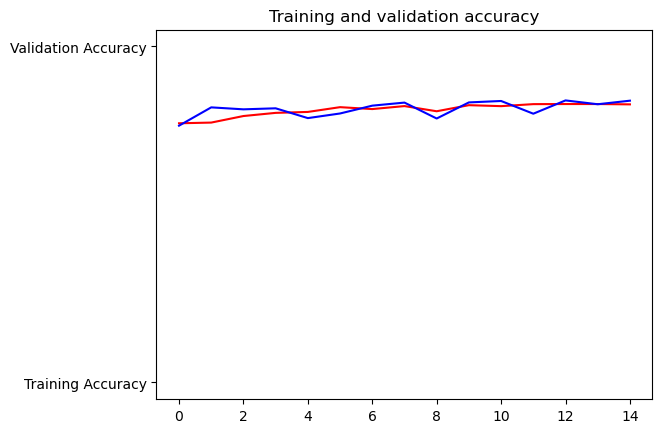

In [19]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()


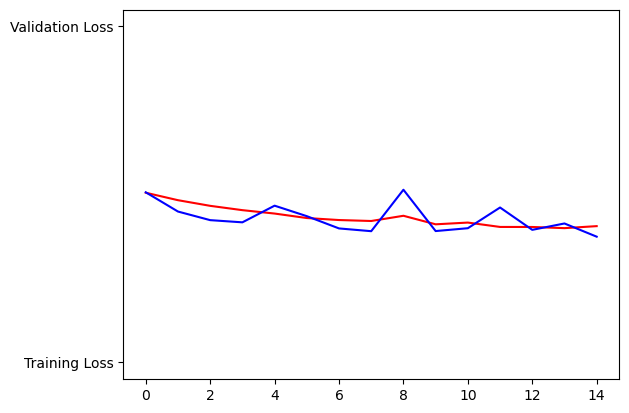

In [20]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()
# Desired output. Charts with training and validation metrics. No crash :)